In [53]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

# Market Analysis

## Deliveroo

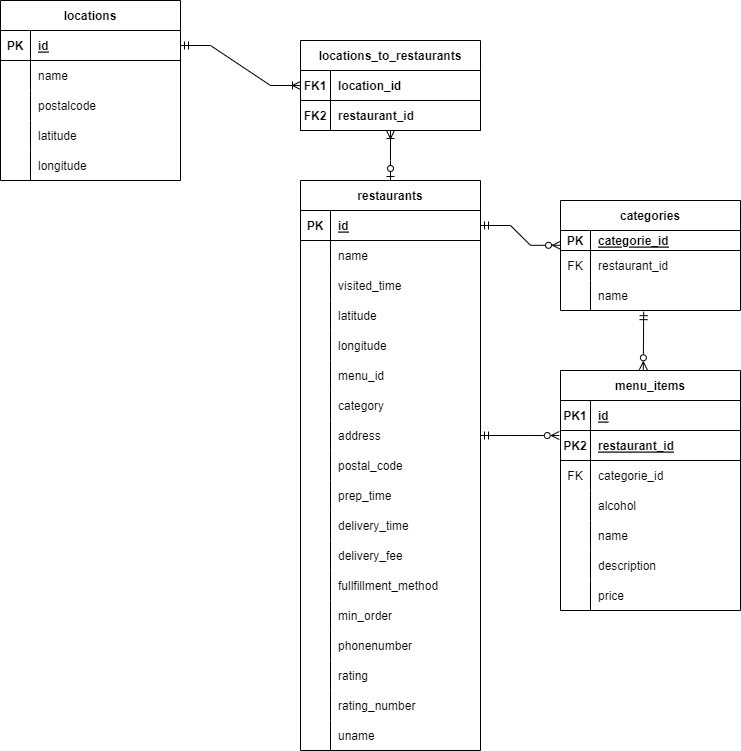

In [60]:
conn_deliveroo = sqlite3.connect("./Databases/deliveroo.db")

### Map locations offering kapsalons and their average price.

In [64]:
query = """
    SELECT restaurants.name as name, ROUND(AVG(menu_items.price), 2) as avg_price, 
    restaurants.latitude as latitude, restaurants.longitude as longitude
    FROM menu_items
    JOIN restaurants ON restaurants.id = menu_items.restaurant_id
    WHERE menu_items.name LIKE "%kapsalon%"
    GROUP BY restaurants.name;
"""

data_deliveroo = pd.read_sql(query, conn_deliveroo)

In [66]:
geo_data_deliveroo = gpd.GeoDataFrame(data_deliveroo, geometry=gpd.points_from_xy(data_deliveroo.longitude, data_deliveroo.latitude), crs="EPSG:4326")

In [67]:
geo_data_deliveroo.explore()

## TakeAway

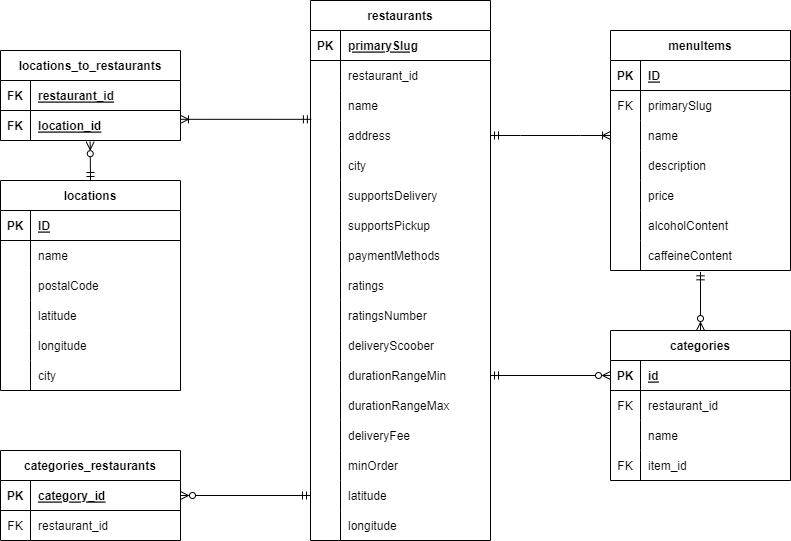

In [70]:
conn_takeaway = sqlite3.connect("./Databases/takeaway.db")

### Map locations offering kapsalons and their average price.

In [75]:
query = """
    SELECT COUNT(DISTINCT primarySlug)
    FROM menuItems
    WHERE name LIKE "%kapsalon%"
"""

pd.read_sql(query, conn_takeaway)

,COUNT(DISTINCT primarySlug)
0,867


## UberEats

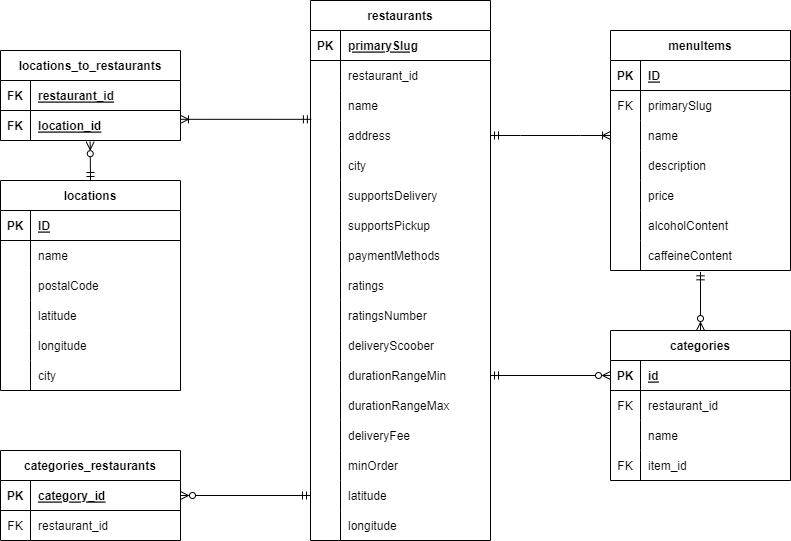

In [63]:
conn_ubereats = sqlite3.connect("./Databases/ubereats.db")